In [ ]:
#@title Import library
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

In [ ]:
#@title Load and preprocess image
def load_image(image_path, max_size=400):
    image = Image.open(image_path).convert('RGB')

    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255)),
        transforms.Normalize(mean=[103.939, 116.779, 123.68], std=[1, 1, 1])  # BGR normalization
    ])

    image = transform(image).unsqueeze(0)
    return image.to(device)

In [ ]:
#@title Deprocess image for display
def deprocess(tensor):
    tensor = tensor.clone().detach()
    tensor = tensor.squeeze(0)
    tensor = tensor.cpu().numpy()
    tensor[0] += 103.939
    tensor[1] += 116.779
    tensor[2] += 123.68
    tensor = tensor[[2, 1, 0]]  # BGR to RGB
    tensor = np.clip(tensor, 0, 255).astype('uint8')
    return np.transpose(tensor, (1, 2, 0))

In [ ]:
#@title Display image using matplotlib
def display_image(tensor):
    img = deprocess(tensor)
    plt.imshow(img)
    plt.axis('off')

In [ ]:
#@title Content loss
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, x):
        self.loss = torch.mean((x - self.target) ** 2)
        return x

In [ ]:
#@title Style loss using Gram matrix
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = self.gram_matrix(target_feature).detach()

    def forward(self, x):
        G = self.gram_matrix(x)
        self.loss = torch.mean((G - self.target) ** 2)
        return x

    def gram_matrix(self, x):
        b, c, h, w = x.size()
        features = x.view(c, h * w)
        G = torch.mm(features, features.t())
        return G / (c * h * w)

In [ ]:
#@title Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#@title Download sample image for test model
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/c/c0/Golden_Retriever_with_tennis_ball.jpg/960px-Golden_Retriever_with_tennis_ball.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg

--2025-07-03 02:08:09--  https://upload.wikimedia.org/wikipedia/commons/thumb/c/c0/Golden_Retriever_with_tennis_ball.jpg/960px-Golden_Retriever_with_tennis_ball.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211932 (207K) [image/jpeg]
Saving to: ‘960px-Golden_Retriever_with_tennis_ball.jpg’

960px-Golden_Retrie 100%[===================>] 206.96K  1.05MB/s    in 0.2s    

2025-07-03 02:08:09 (1.05 MB/s) - ‘960px-Golden_Retriever_with_tennis_ball.jpg’ saved [211932/211932]

--2025-07-03 02:08:10--  https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org

In [ ]:
#@title Load images
content_path = "960px-Golden_Retriever_with_tennis_ball.jpg"
style_path = "1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"
content_img = load_image(content_path)
style_img = load_image(style_path)

In [ ]:
#@title Use pretrained VGG19
cnn = models.vgg19(pretrained=True).features.to(device).eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 132MB/s]


In [ ]:
#@title Chosen layers
content_layer = 'conv_4'
style_layers = ['conv_1', 'conv_3', 'conv_5']

In [ ]:
#@title Construct model and insert loss layers
def get_model_and_losses(cnn, content_img, style_img):
    content_losses = []
    style_losses = []

    model = nn.Sequential()
    i = 0  # increment every conv layer

    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')

        model.add_module(name, layer)

        if name == content_layer:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f'content_loss_{i}', content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target = model(style_img).detach()
            style_loss = StyleLoss(target)
            model.add_module(f'style_loss_{i}', style_loss)
            style_losses.append(style_loss)

    # Truncate the model after the last loss layer
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:i+1]

    return model, content_losses, style_losses

In [ ]:
#@title Training loop
def run_style_transfer(content_img, style_img, num_steps=50, style_weight=1e6, content_weight=1e1):
    model, content_losses, style_losses = get_model_and_losses(cnn, content_img, style_img)

    generated = content_img.clone().requires_grad_(True)

    optimizer = optim.Adam([generated], lr=0.01)

    best_loss = float('inf')
    best_img = None
    generated_images = []

    for step in range(num_steps):
        start_cpu = time.process_time()
        start_wall = time.time()

        optimizer.zero_grad()
        model(generated)
        style_score = 0
        content_score = 0

        for sl in style_losses:
            style_score += sl.loss
        for cl in content_losses:
            content_score += cl.loss

        loss = style_weight * style_score + content_weight * content_score
        loss.backward()
        optimizer.step()

        end_cpu = time.process_time()
        end_wall = time.time()

        if loss.item() < best_loss:
            best_loss = loss.item()
            best_img = generated.clone().detach()

        print(f"CPU time: {int((end_cpu - start_cpu) * 1e6)} µs")
        print(f"Wall time: {int((end_wall - start_wall) * 1e6)} µs")
        print(f"Iteration {step + 1}")
        print(f"Total loss: {loss.item():.4e}")
        generated_images.append(generated.clone().detach())

    return best_img, generated_images

CPU time: 103982 µs
Wall time: 294064 µs
Iteration 1
Total loss: 4.0651e+10
CPU time: 4303 µs
Wall time: 4323 µs
Iteration 2
Total loss: 4.0601e+10
CPU time: 3518 µs
Wall time: 3551 µs
Iteration 3
Total loss: 4.0550e+10
CPU time: 3417 µs
Wall time: 3451 µs
Iteration 4
Total loss: 4.0500e+10
CPU time: 3413 µs
Wall time: 3449 µs
Iteration 5
Total loss: 4.0450e+10
CPU time: 3515 µs
Wall time: 3547 µs
Iteration 6
Total loss: 4.0400e+10
CPU time: 3408 µs
Wall time: 3431 µs
Iteration 7
Total loss: 4.0350e+10
CPU time: 3381 µs
Wall time: 3407 µs
Iteration 8
Total loss: 4.0300e+10
CPU time: 3427 µs
Wall time: 3420 µs
Iteration 9
Total loss: 4.0250e+10
CPU time: 3335 µs
Wall time: 3369 µs
Iteration 10
Total loss: 4.0200e+10
CPU time: 3320 µs
Wall time: 3365 µs
Iteration 11
Total loss: 4.0150e+10
CPU time: 4061 µs
Wall time: 4281 µs
Iteration 12
Total loss: 4.0100e+10
CPU time: 3424 µs
Wall time: 3453 µs
Iteration 13
Total loss: 4.0051e+10
CPU time: 3425 µs
Wall time: 3457 µs
Iteration 14
Total 

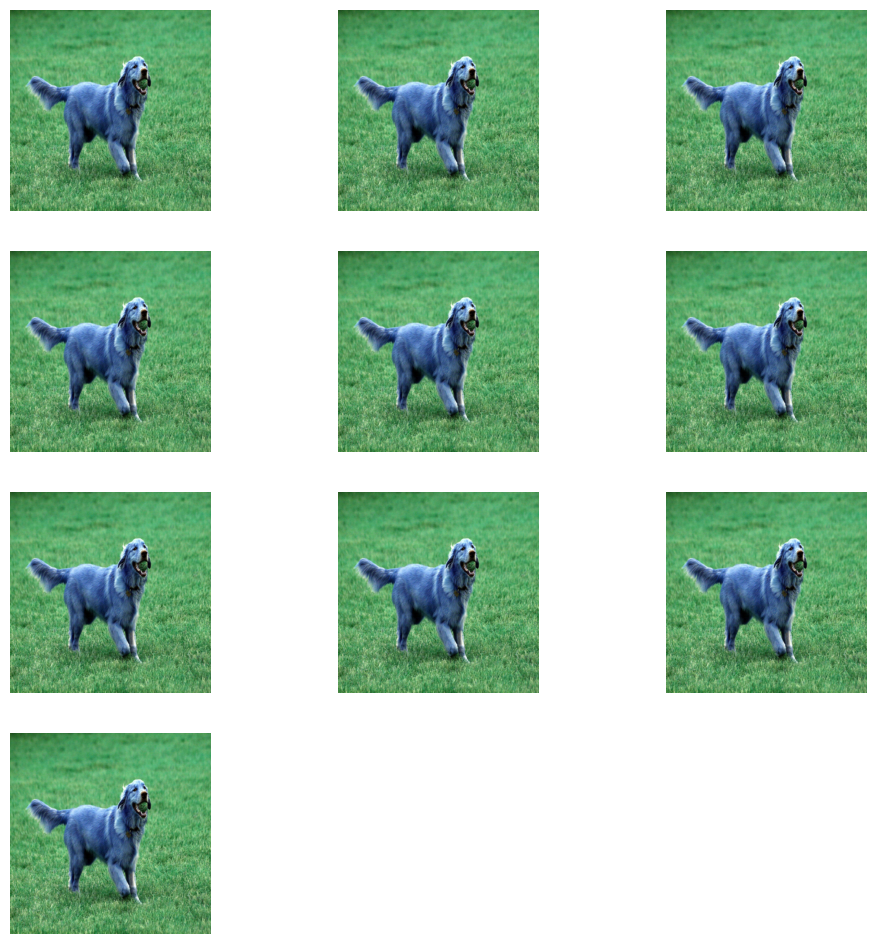

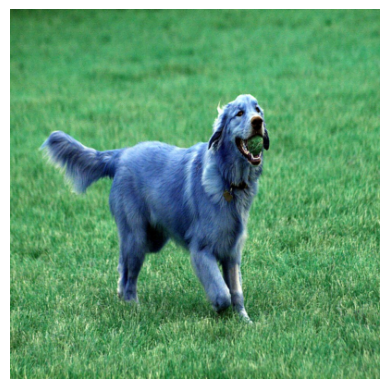

In [ ]:
#@title Run training
final_img, generated_images = run_style_transfer(content_img, style_img)

# Display samples
plt.figure(figsize=(12, 12))
for i in range(10):
    plt.subplot(4, 3, i + 1)
    display_image(generated_images[i + 39])
plt.show()

# Display final image
display_image(final_img)

In [ ]:
!pip install streamlit pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 129.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 127.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 9.1 MB/s eta 0:00:00


In [ ]:
#@title Write utils.py as a model modules
%%writefile utils.py
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import numpy as np
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_image(image_file, shape=(512, 512)):
    image = Image.open(image_file).convert('RGB')
    image = image.resize(shape)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255)),
        transforms.Normalize(mean=[103.939, 116.779, 123.68], std=[1, 1, 1])
    ])
    image = transform(image).unsqueeze(0)
    return image.to(device)

def deprocess(tensor):
    tensor = tensor.clone().detach().squeeze(0).cpu().numpy()
    tensor[0] += 103.939
    tensor[1] += 116.779
    tensor[2] += 123.68
    tensor = tensor[[2, 1, 0]]
    tensor = np.clip(tensor, 0, 255).astype('uint8')
    return np.transpose(tensor, (1, 2, 0))

class ContentLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = target.detach()
    def forward(self, x):
        self.loss = torch.mean((x - self.target)**2)
        return x

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super().__init__()
        self.target = self.gram_matrix(target_feature).detach()
    def gram_matrix(self, x):
        b, c, h, w = x.size()
        features = x.view(c, h * w)
        return torch.mm(features, features.t()) / (c * h * w)
    def forward(self, x):
        G = self.gram_matrix(x)
        self.loss = torch.mean((G - self.target) ** 2)
        return x

def get_model_and_losses(cnn, content_img, style_img, content_layer='conv_4',
                         style_layers=['conv_1', 'conv_3', 'conv_5']):
    model = nn.Sequential()
    content_losses, style_losses = [], []
    i = 0

    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        else:
            continue

        model.add_module(name, layer)

        if name == content_layer:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f'content_loss_{i}', content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target = model(style_img).detach()
            style_loss = StyleLoss(target)
            model.add_module(f'style_loss_{i}', style_loss)
            style_losses.append(style_loss)

    # Cut after last loss
    for j in range(len(model) - 1, -1, -1):
        if isinstance(model[j], ContentLoss) or isinstance(model[j], StyleLoss):
            break
    model = model[:j+1]

    return model, content_losses, style_losses

def run_style_transfer(content_img, style_img, num_steps=50, style_weight=1e6, content_weight=1e1):
    cnn = models.vgg19(pretrained=True).features.to(device).eval()
    model, content_losses, style_losses = get_model_and_losses(cnn, content_img, style_img)

    generated = content_img.clone().requires_grad_(True)
    optimizer = optim.Adam([generated], lr=0.01)

    for step in range(num_steps):
        optimizer.zero_grad()
        model(generated)

        style_score = sum(sl.loss for sl in style_losses)
        content_score = sum(cl.loss for cl in content_losses)
        loss = style_weight * style_score + content_weight * content_score
        loss.backward()
        optimizer.step()

    return generated.detach()

Writing utils.py


In [ ]:
#@title Write app.py as main streamlit program
%%writefile app.py
import streamlit as st
from utils import load_image, run_style_transfer, deprocess
from PIL import Image
import io
import matplotlib.pyplot as plt

st.set_page_config(page_title="Neural Style Transfer", layout="centered")

st.title("🎨 Neural Style Transfer with PyTorch")
st.markdown("Upload a **content image** and a **style image** to generate a stylized result.")

content_file = st.file_uploader("Upload Content Image", type=['jpg', 'jpeg', 'png'])
style_file = st.file_uploader("Upload Style Image", type=['jpg', 'jpeg', 'png'])

steps = st.slider("Number of Iterations", min_value=10, max_value=200, value=50, step=10)
generate_btn = st.button("Generate Stylized Image")

TARGET_SHAPE = (512, 512)

if content_file and style_file and generate_btn:
    with st.spinner("Running Neural Style Transfer..."):
        content_image = load_image(content_file, shape=TARGET_SHAPE)
        style_image = load_image(style_file, shape=TARGET_SHAPE)
        output = run_style_transfer(content_image, style_image, num_steps=steps)

        result_image = deprocess(output)

        st.subheader("Result")
        st.image(result_image, caption="Stylized Output", use_column_width=True)

        pil_image = Image.fromarray(result_image)
        buf = io.BytesIO()
        pil_image.save(buf, format="PNG")
        st.download_button("📥 Download Image", data=buf.getvalue(), file_name="stylized_result.png", mime="image/png")

Writing app.py


In [ ]:
#@title streamlit + ngrok running
from pyngrok import ngrok
import os

NGROK_AUTH_TOKEN = "YOUR_NGROK_AUTHTOKEN" #@param {type:"string"}
os.environ["NGROK_AUTH_TOKEN"] = NGROK_AUTH_TOKEN

!ngrok authtoken $NGROK_AUTH_TOKEN

# Hentikan ngrok sebelumnya
ngrok.kill()

# Jalankan streamlit di background
!nohup streamlit run app.py --server.port 8501 > /dev/null 2>&1 &

# Ngrok forwarding
public_url = ngrok.connect(8501)
print("🌐 Web UI:", public_url)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
🌐 Web UI: NgrokTunnel: "https://28d5-35-198-224-143.ngrok-free.app" -> "http://localhost:8501"
